Using the ipynb file provided:-
CC BY 4.0 DEED
Attribution 4.0 International

In [1]:

import json, time, urllib.parse

#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

I've set up constants, parameters, and a template for making API requests to the Wikimedia Pageviews API. It defines the endpoint for pageviews requests, the request parameters for per-article requests, and specifies some constraints like API latency and rate limits. It reads a CSV file ('thank_the_academy.AUG.2023.csv') to extract a list of English Wikipedia article titles and prepares them for API requests. The template is used to map parameter values, such as project, access type, article name, and date range, for each API request. I have added double quotes in the template so we can call different access types.

In [ ]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests

API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'
# API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/all-projects/all-access/all-agents/monthly/2015100100/2016103000'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error
REQUEST_HEADERS = {
    'User-Agent': '<ananya27@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}
import pandas as pd
# This is just a list of English Wikipedia article titles that we can use for example requests
df = pd.read_csv('/content/thank_the_academy.AUG.2023.csv - thank_the_academy.AUG.2023b.csv.csv')

# Extract the first column (assuming it's named 'column_name') into a list
ARTICLE_TITLES = df['name'].tolist()
# ARTICLE_TITLES=ARTICLE_TITLES[:3]
# display(ARTICLE_TITLES)
# ARTICLE_TITLES = [ 'Moonbird', 'The More the Merrier', 'Avatar: The Way of Water' ]


ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2023100100"    # this is likely the wrong end date
}


I created a Python function called request_pageviews_per_article to request pageview data from the Wikimedia API. This function allows me  to get pageview statistics for a particular Wikipedia article and specify either desktop or mobile access data. The function takes care of constructing the API request URL, making the request, and returning the response in JSON format.

In [3]:
def request_pageviews_per_article(article_title = None,
                                  access_type = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):


    if not article_title or not access_type: return None

    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    request_template['access'] = access_type


    request_url = endpoint_url+endpoint_params.format(**request_template)
    print(request_url)

    # make the request
    try:

        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

It accepts a list of article titles and, for each article, fetches pageview statistics separately for the three access types: mobile-app, mobile-web, and desktop. Afterward, it consolidates the mobile-app and mobile-web pageviews into a unified count for mobile pageviews.

In [4]:
def fetch_data():

    mobile_response_list = []
    desktop_response_list = []
    cumu_response_list = []
    for article in ARTICLE_TITLES:
        try:
            mob_app_views = request_pageviews_per_article(article, 'mobile-app')['items']
            mob_web_views = request_pageviews_per_article(article, 'mobile-web')['items']
            desk_views = request_pageviews_per_article(article, 'desktop')['items']
            cumu_views = request_pageviews_per_article(article, 'all-access')['items']

            mob_views = []
            for app_view, web_view, desk_view, cumu_view in zip(mob_app_views, mob_web_views, desk_views, cumu_views):
                mob_view = app_view
                mob_view['views'] += web_view['views']

                del mob_view['access']
                mob_views.append(mob_view)
                del desk_view['access']
                del cumu_view['access']

            mobile_response_list += mob_views
            desktop_response_list += desk_views
            cumu_response_list += cumu_views

        except:
            # print(e)
            print(f'Data not found for: {article}')

    with open('academy_monthly_mobile_201507-202309.json', 'w') as f:
        json.dump(mobile_response_list, f)

    with open('academy_monthly_desktop_201507-202309.json', 'w') as f:
        json.dump(desktop_response_list, f)

    with open('academy_monthly_cumulative_201507-202309.json', 'w') as f:
        json.dump(cumu_response_list, f)

### Uncomment the below line to download a fresh copy of json files containing the article view data
fetch_data()

Streaming output truncated to the last 5000 lines.
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/desktop/user/Bridge_of_Spies_%28film%29/monthly/2015070100/2023100100
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/user/Bridge_of_Spies_%28film%29/monthly/2015070100/2023100100
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/mobile-app/user/The_Big_Short_%28film%29/monthly/2015070100/2023100100
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/mobile-web/user/The_Big_Short_%28film%29/monthly/2015070100/2023100100
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/desktop/user/The_Big_Short_%28film%29/monthly/2015070100/2023100100
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/user/The_Big_Short_%28film%29/monthly/2015070100/2023100100
https://wikimedia.org/api/rest_v1/metri

Load a JSON file into a Pandas DataFrame, where the timestamp column is converted into a datetime object, and then return the resulting DataFrame.
@param file - the file path to the JSON file
@returns a DataFrame

In [5]:
def read_json_to_df(file):

    df = pd.read_json(file,
                      convert_dates=False,
                      dtype={'timestamp': pd.StringDtype})
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
    return df

mobile_df = read_json_to_df('academy_monthly_mobile_201507-202309.json')
desktop_df = read_json_to_df('academy_monthly_desktop_201507-202309.json')
cumu_df = read_json_to_df('academy_monthly_cumulative_201507-202309.json')

mobile_df.to_csv('academy_monthly_mobile_201507-202309.csv')
desktop_df.to_csv('academy_monthly_desktop_201507-202309.csv')
cumu_df.to_csv('academy_monthly_cumulative_201507-202309.csv')
mobile_df.dtypes

project                object
article                object
granularity            object
timestamp      datetime64[ns]
agent                  object
views                   int64
dtype: object

Figure showing Maximum Average and Minimum Average articles


Given a DataFrame as input, this function performs the following steps: first, it groups the DataFrame by articles; then, it calculates the mean views for each article. Afterward, it identifies the rows with the maximum and minimum values in the views column and returns the corresponding data for these articles

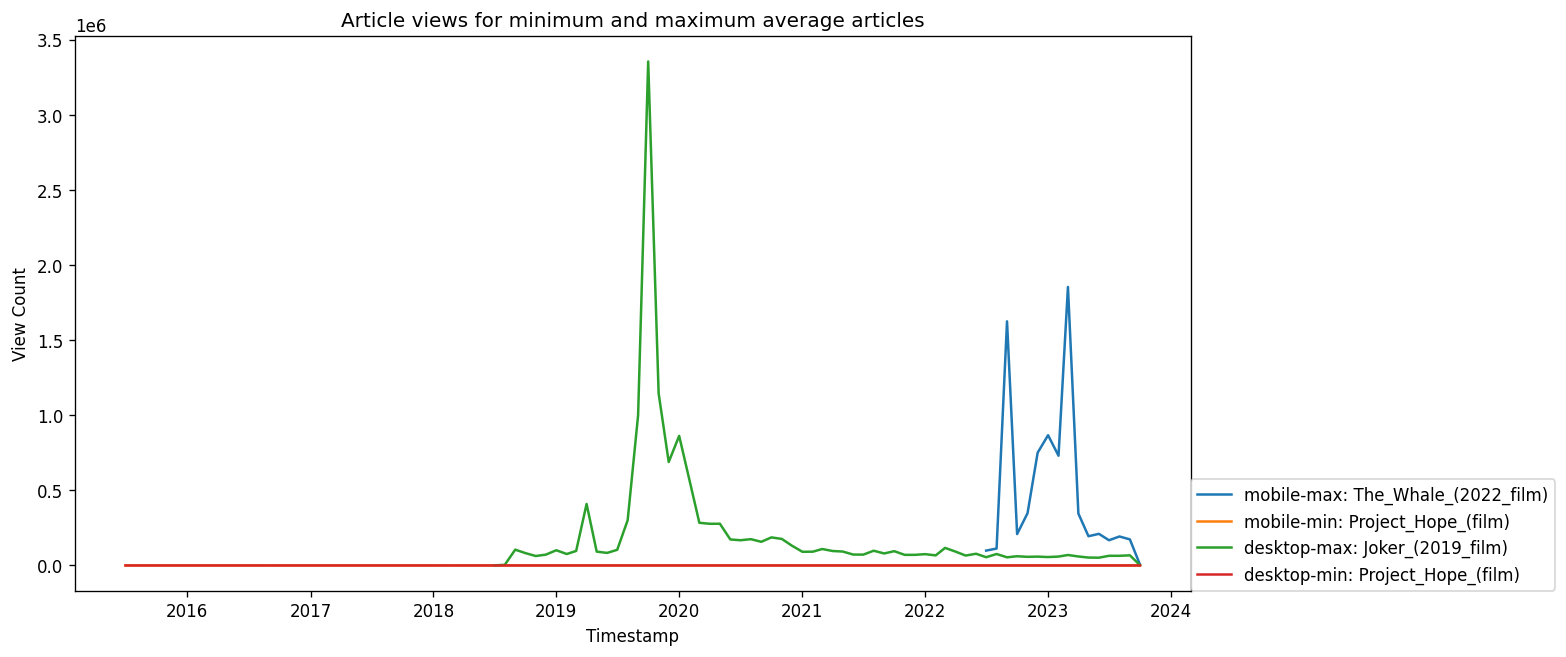

In [6]:
def get_max_min_avg_articles(df):


    df_grpd = df.groupby('article').mean('views')
    max_view_article = df_grpd.loc[df_grpd['views'].idxmax()].name
    min_view_article = df_grpd.loc[df_grpd['views'].idxmin()].name

    return df[df['article'] == max_view_article], df[df['article'] == min_view_article]

mob_max_df, mob_min_df = get_max_min_avg_articles(mobile_df)
desk_max_df, desk_min_df = get_max_min_avg_articles(desktop_df)

def plot_line(df, part_label):
    """
    The function takes a dataframe and a string as input, and plots the views over time for the dataframe, with the label
    of the plot being the string plus the article name
    @param df - the dataframe to plot
    @param part_label - a string that will be used to label the plot
    """
    plt.plot(df['timestamp'],df['views'], label=part_label + df.iloc[0]['article'])
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=120)
plot_line(mob_max_df, 'mobile-max: ')
plot_line(mob_min_df, 'mobile-min: ')
plot_line(desk_max_df, 'desktop-max: ')
plot_line(desk_min_df, 'desktop-min: ')
plt.xlabel('Timestamp')
plt.ylabel('View Count')
plt.title('Article views for minimum and maximum average articles')
plt.legend(prop={'size': 10}, loc=(1, 0))

plt.savefig('Plot1.png')
plt.show()

Figure showing Top 10 Peak Page Views

This function conducts a series of operations on a given DataFrame. Firstly, it groups the DataFrame by article and identifies the articles with the highest number of views. Then, it arranges the DataFrame in descending order according to the view counts and selects the top 10 articles with the most views. Finally, it returns both the list of these top 10 articles and a modified DataFrame that exclusively includes these top-ranking articles. This function is a valuable tool for quickly identifying and working with the most popular articles in the dataset.





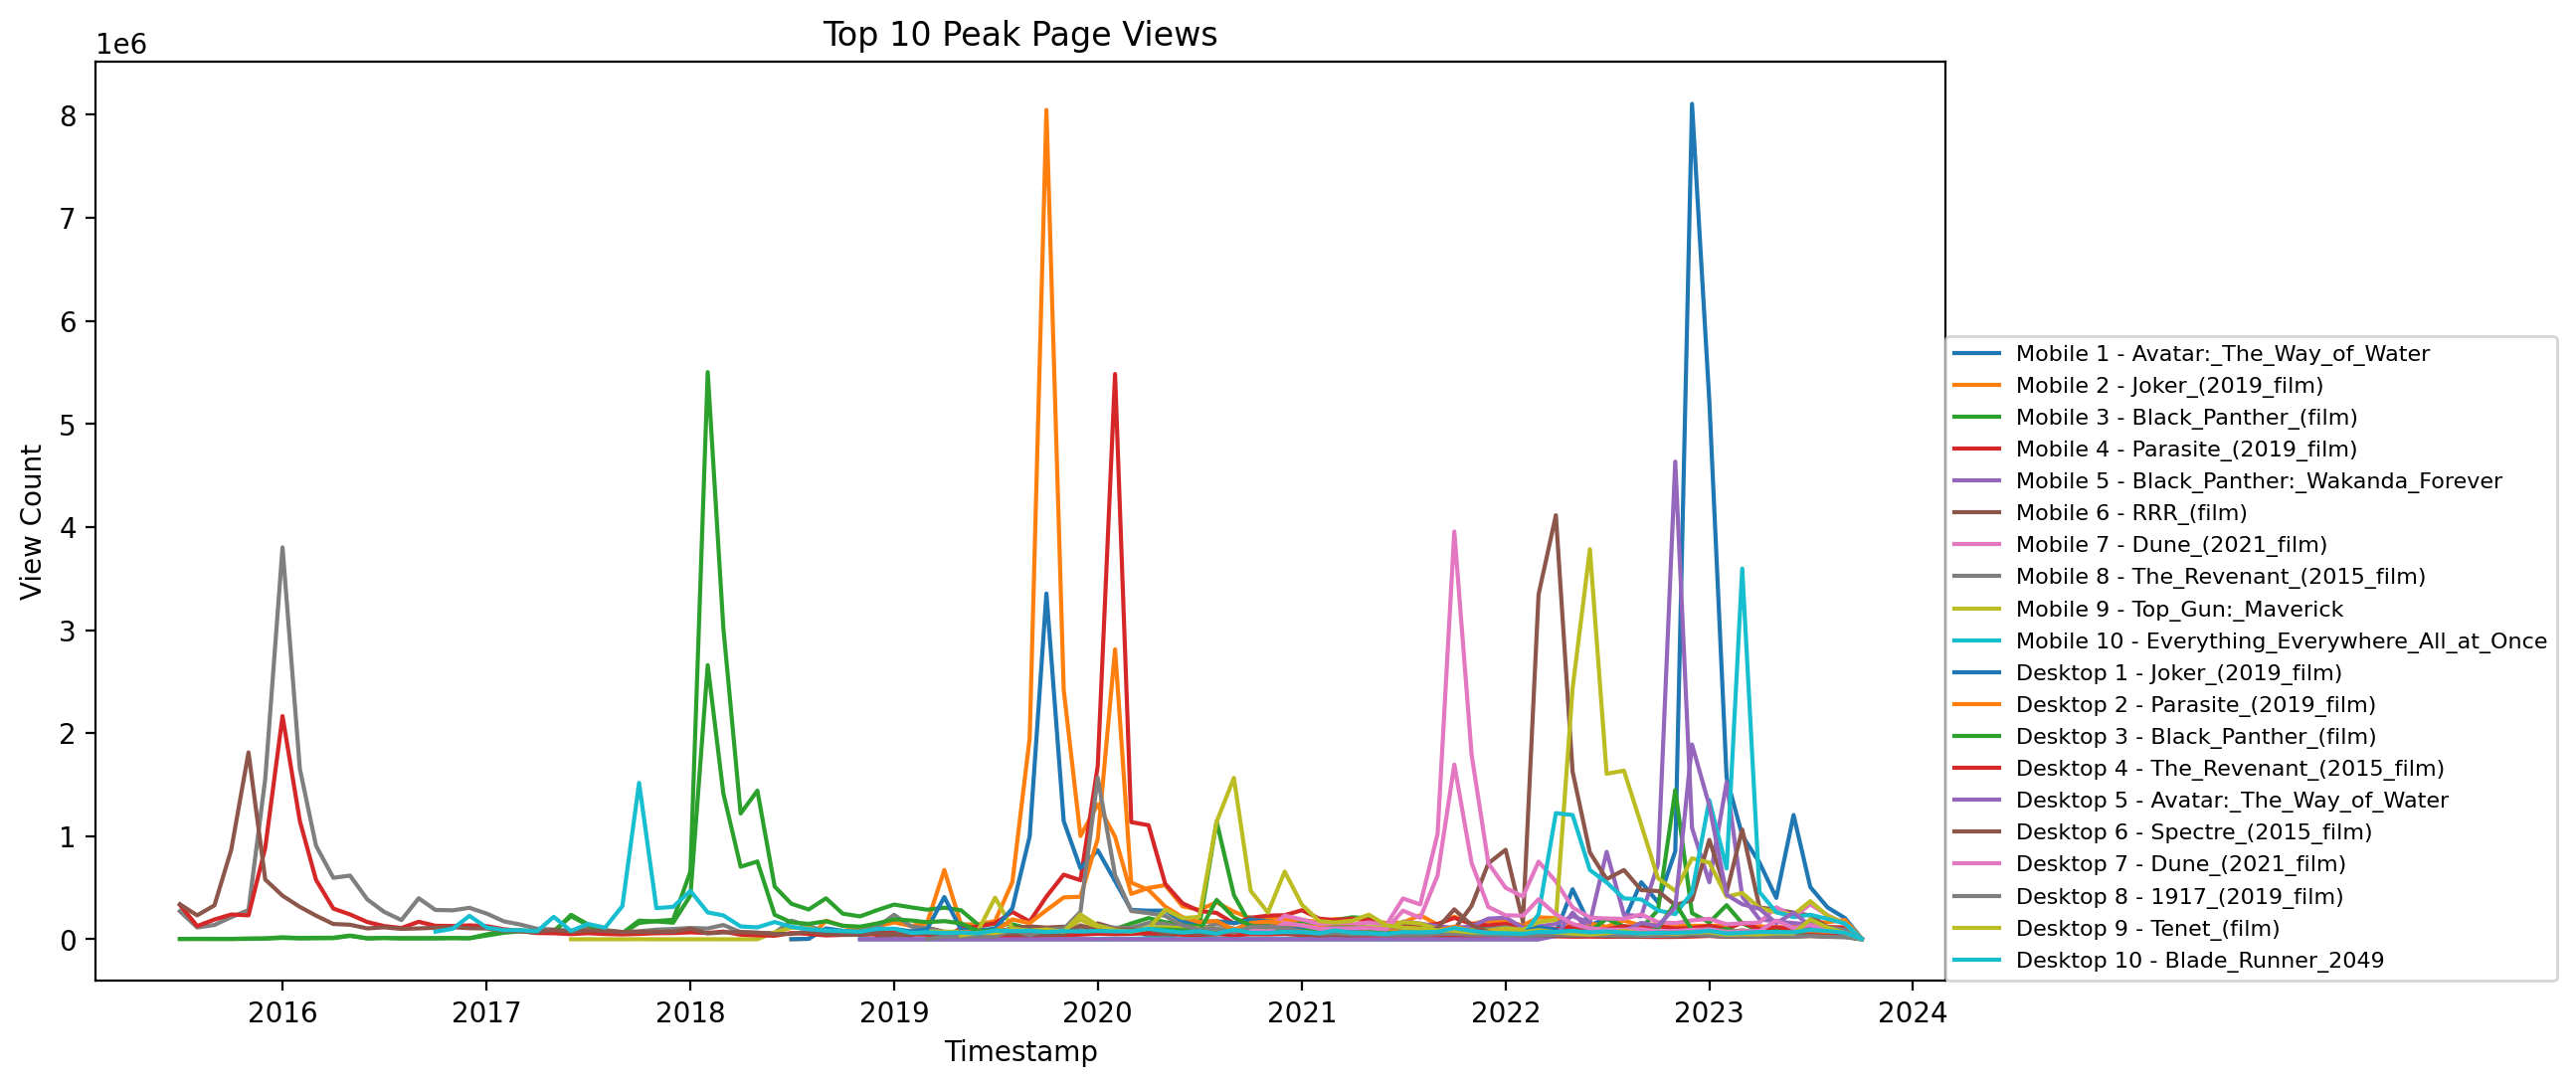

In [7]:
def get_top_10(df):

    df_grpd = df.groupby(['article'], as_index=False).max('views').sort_values(by=['views'], ascending=False).iloc[:10]
    return df_grpd['article'], df[df['article'].isin(df_grpd['article'].to_list())]

mobile_top10, mobile_top10_df = get_top_10(mobile_df)
desktop_top10, desktop_top10_df = get_top_10(desktop_df)

plt.figure(figsize=(12, 6), dpi=200)
for idx, article in enumerate(mobile_top10):
    plot_line(mobile_top10_df[mobile_top10_df['article'] == article], f'Mobile {idx+1} - ')


for idx, article in enumerate(desktop_top10):
    plot_line(desktop_top10_df[desktop_top10_df['article'] == article], f'Desktop {idx+1} - ')

plt.xlabel('Timestamp')
plt.ylabel('View Count')
plt.title('Top 10 Peak Page Views')
plt.legend(prop={'size': 8}, loc=(1, 0))

plt.savefig('Plot2.png')
plt.show()

Figure showing articles with fewest months of Data

This function provides a list of the ten articles with the lowest monthly view counts. Given a DataFrame as input, it identifies and extracts the ten articles with the fewest views per month. The result is returned as a tuple containing two DataFrames, making it easy to work with this subset of data for further analysis or reporting purposes.

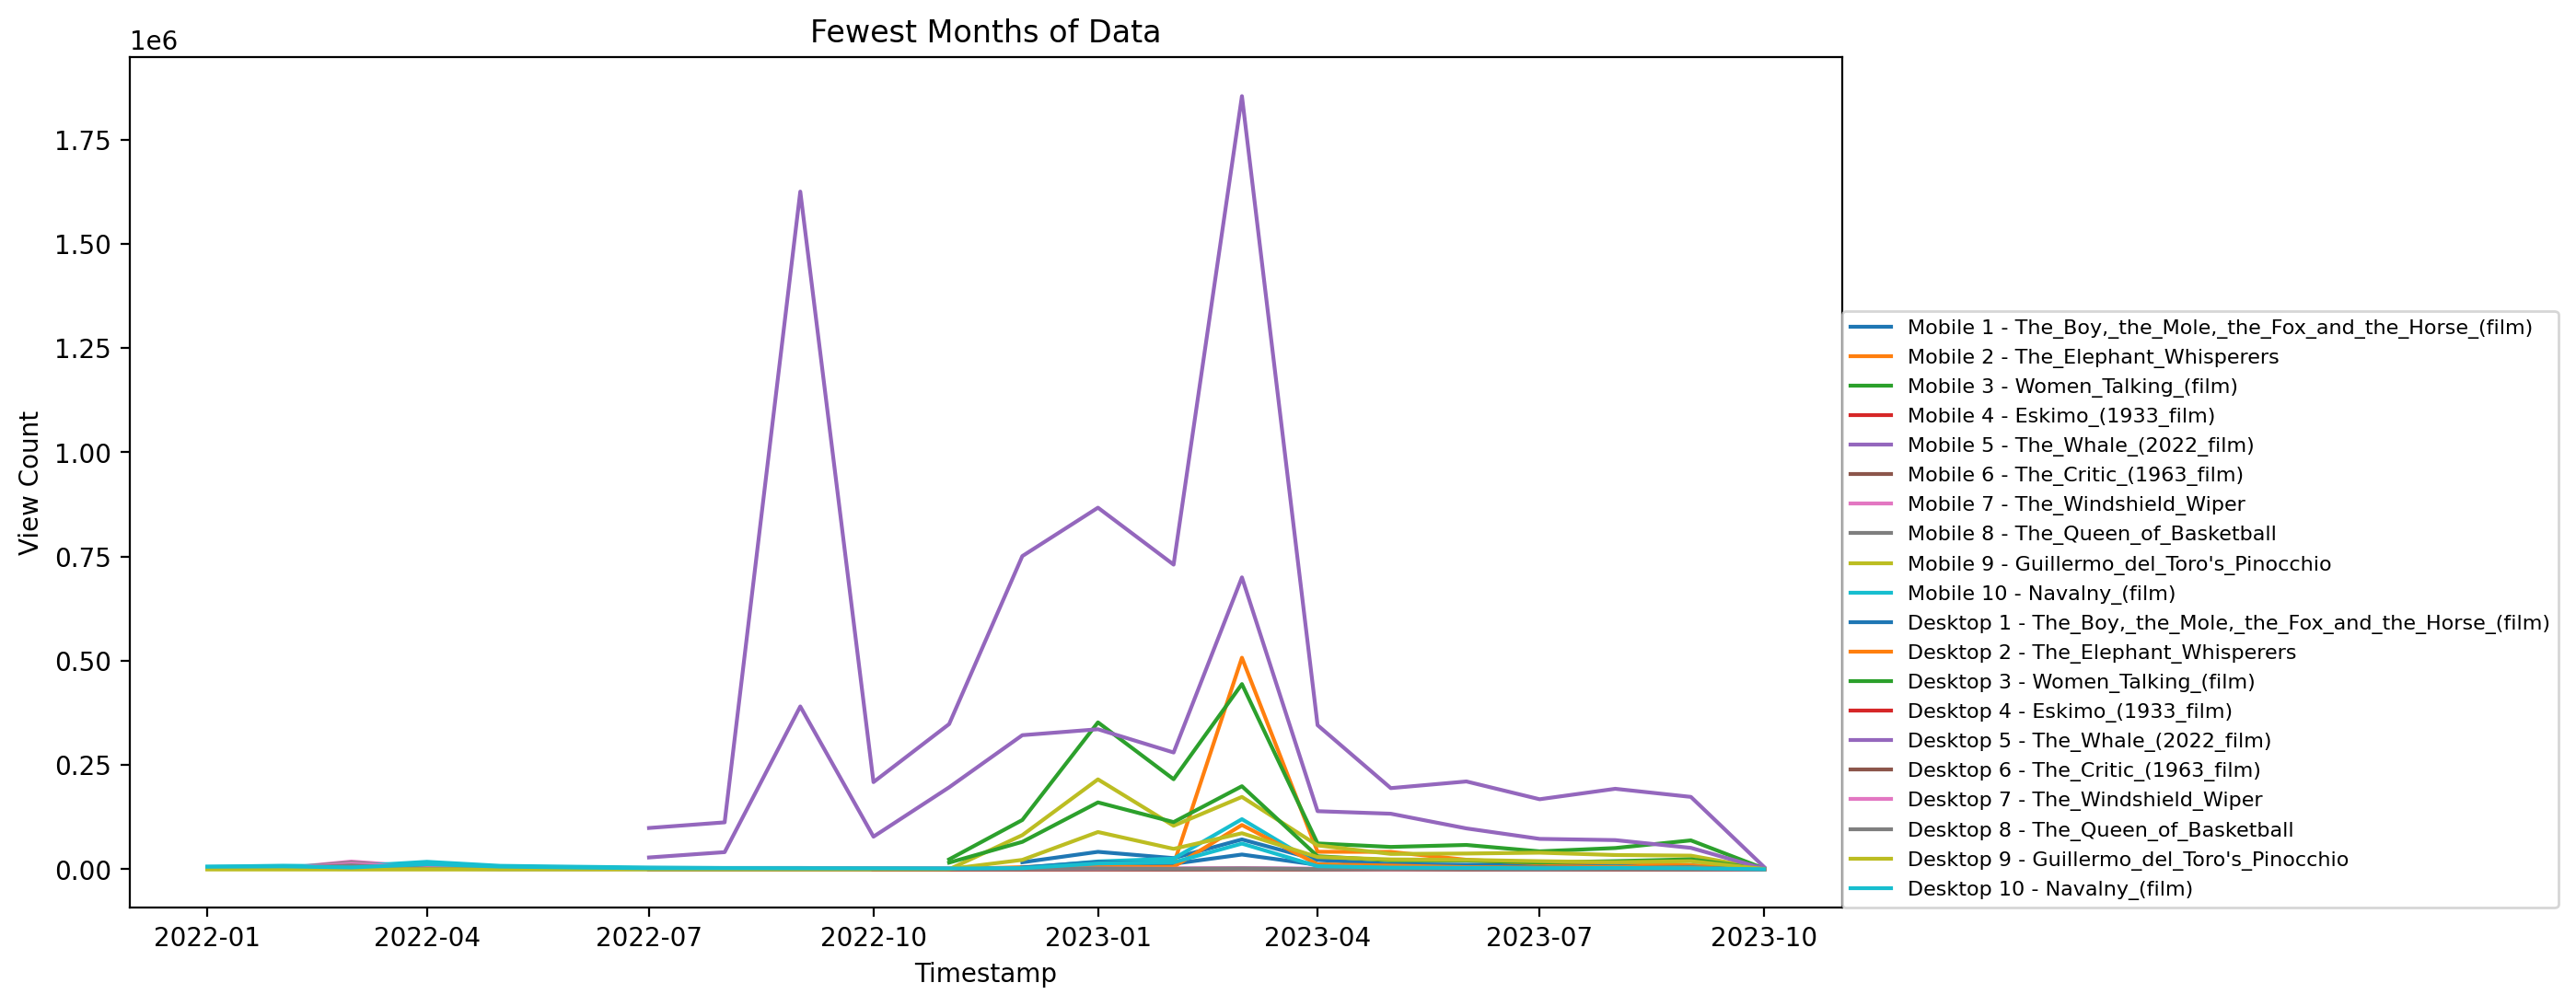

In [8]:
def articles_by_least_view_months(df):

    df_grpd = df[['article', 'views']]\
                .groupby(['article'], as_index=False)\
                .count()\
                .sort_values(by=['views'])\
                .iloc[:10]\
                .rename(columns={'views': 'count'})

    return df_grpd['article'], df[df['article'].isin(df_grpd['article'].to_list())]

mobile_least, mobile_least_df = articles_by_least_view_months(mobile_df)
desktop_least, desktop_least_df = articles_by_least_view_months(desktop_df)

plt.figure(figsize=(12, 6), dpi=200)
for idx, article in enumerate(mobile_least):
    plot_line(mobile_least_df[mobile_least_df['article'] == article], f'Mobile {idx+1} - ')


for idx, article in enumerate(desktop_least):
    plot_line(desktop_least_df[desktop_least_df['article'] == article], f'Desktop {idx+1} - ')

plt.xlabel('Timestamp')
plt.ylabel('View Count')
plt.title('Fewest Months of Data')
plt.legend(prop={'size': 8}, loc=(1, 0))

plt.savefig('Plot3.png')
plt.show()